In [1]:
import os
import tensorflow as tf

In [2]:
train_dir = 'data3a/training'
val_dir = 'data3a/validation'

In [3]:
img_width, img_height = 150, 150

In [4]:
epoch = 50
batch_size=16

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50


resnet_model = Sequential()
pretrained_model = ResNet50(
    include_top=False,
    input_shape=(img_width,img_height,3),
    pooling='average',
    classes=3,
    weights='imagenet'
)
for layer in pretrained_model.layers:
    layer.trainable=False


resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
# minor moderate and severe (3)
resnet_model.add(Dense(3, activation='softmax'))

In [8]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 512)               26214912  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 49804163 (189.99 MB)
Trainable params: 26216451 (100.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [9]:
#Model compile
from tensorflow.keras.optimizers import Adam
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import CSVLogger

# Define the CSVLogger

log_folder = "traininglog"
log_file_path = f"{log_folder}/resnet50_training_log.csv"

csv_logger = CSVLogger(log_file_path, append=True)

In [12]:
#Model Train 

import time 
start_time = time.time()

history = resnet_model.fit(train_generator, epochs=epoch, validation_data=val_generator,callbacks=[csv_logger])

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total training time: {elapsed_time:.2f} seconds")

Epoch 1/50
87/87 [==============================] - 68s 725ms/step - loss: 1.9991 - accuracy: 0.3926 - val_loss: 1.1242 - val_accuracy: 0.4718
Epoch 2/50
87/87 [==============================] - 58s 667ms/step - loss: 1.3005 - accuracy: 0.4331 - val_loss: 1.2977 - val_accuracy: 0.3669
Epoch 3/50
87/87 [==============================] - 59s 678ms/step - loss: 1.2349 - accuracy: 0.4512 - val_loss: 0.9760 - val_accuracy: 0.5363
Epoch 4/50
87/87 [==============================] - 61s 701ms/step - loss: 1.0107 - accuracy: 0.5040 - val_loss: 0.8770 - val_accuracy: 0.5887
Epoch 5/50
87/87 [==============================] - 61s 703ms/step - loss: 1.0516 - accuracy: 0.4751 - val_loss: 0.9927 - val_accuracy: 0.4798
Epoch 6/50
87/87 [==============================] - 61s 703ms/step - loss: 1.0383 - accuracy: 0.4772 - val_loss: 1.0262 - val_accuracy: 0.4274
Epoch 7/50
87/87 [==============================] - 61s 706ms/step - loss: 1.0004 - accuracy: 0.4736 - val_loss: 0.8938 - val_accuracy: 0.5806

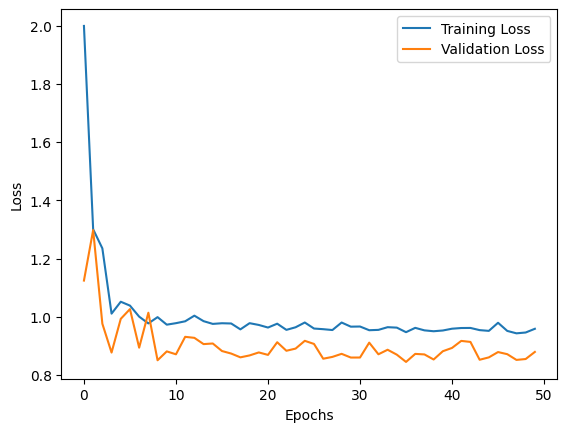

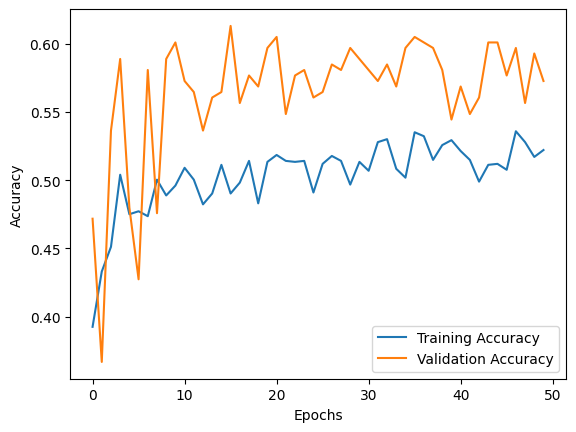

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
from sklearn.metrics import f1_score
# # f1 score
# plt.plot(history.history['f1_score'], label='Training F1 Score')
# plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.show()

8/8 [==============================] - 6s 662ms/step
Confusion Matrix:


C:\Users\sandi\AppData\Local\Temp\ipykernel_16152\1369690478.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
C:\Users\sandi\AppData\Local\Temp\ipykernel_16152\1369690478.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])


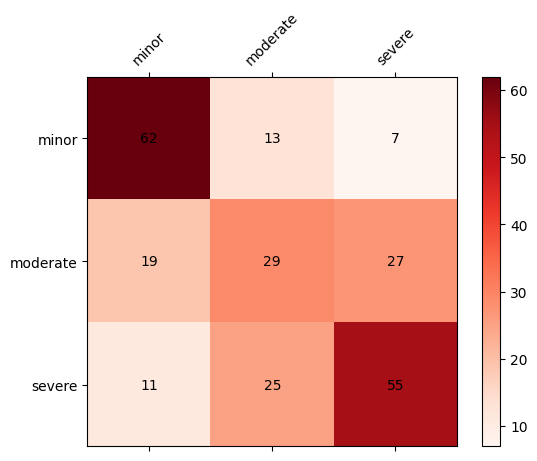

Classification Report:
              precision    recall  f1-score   support

    01-minor       0.67      0.76      0.71        82
 02-moderate       0.43      0.39      0.41        75
   03-severe       0.62      0.60      0.61        91

    accuracy                           0.59       248
   macro avg       0.57      0.58      0.58       248
weighted avg       0.58      0.59      0.58       248



In [13]:
import numpy as np
val_images, val_labels = [], []
class_names = sorted(train_generator.class_indices.keys())
for i in range(len(val_generator)):
    images, labels = val_generator[i]
    val_images.extend(images)
    val_labels.extend(np.argmax(labels, axis=1))


val_images = np.array(val_images)
val_labels = np.array(val_labels)

predictions = resnet_model.predict(val_images)



from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(predictions, axis=1)
y_true = val_labels

confusion_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap='Reds')

cbar = fig.colorbar(cax)

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center')
print('Confusion Matrix:')

plt.show()



report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:')
print(report)

In [14]:
resnet_model.save('resnet50-model-bs16-ep50.keras')
print('model saved')

model saved


1/1 [==============================] - 0s 103ms/step


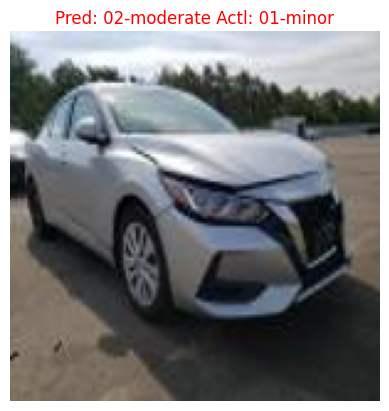

1/1 [==============================] - 0s 96ms/step


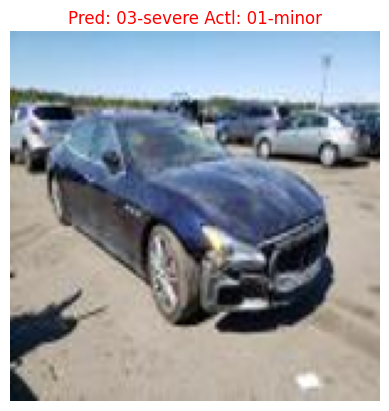

1/1 [==============================] - 0s 102ms/step


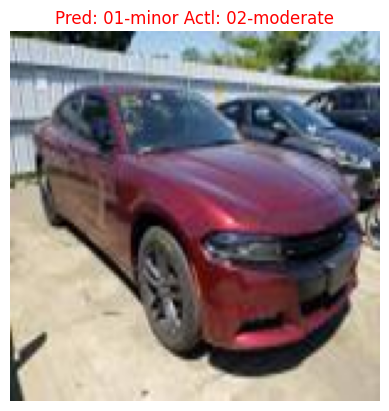

1/1 [==============================] - 0s 104ms/step


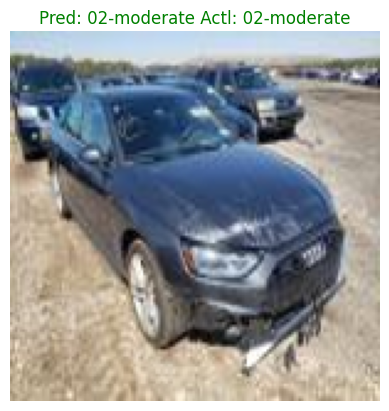

1/1 [==============================] - 0s 94ms/step


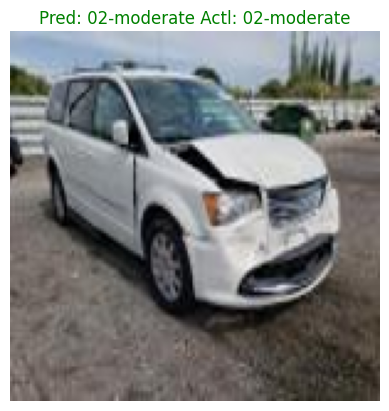

1/1 [==============================] - 0s 83ms/step


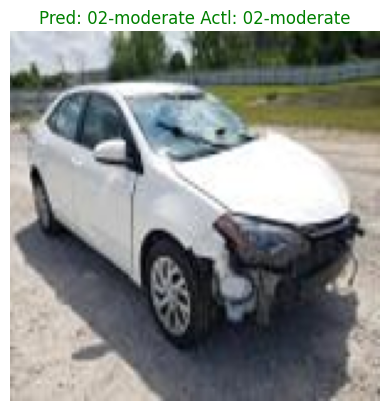

1/1 [==============================] - 0s 94ms/step


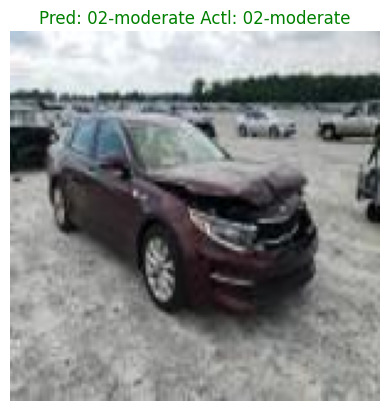

1/1 [==============================] - 0s 100ms/step


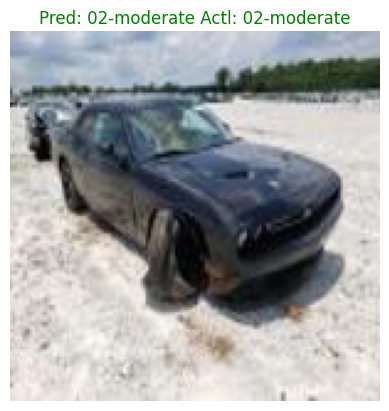

1/1 [==============================] - 0s 96ms/step


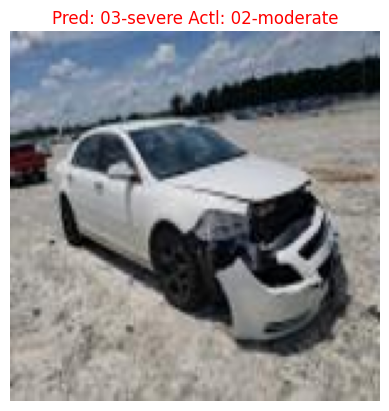

1/1 [==============================] - 0s 94ms/step


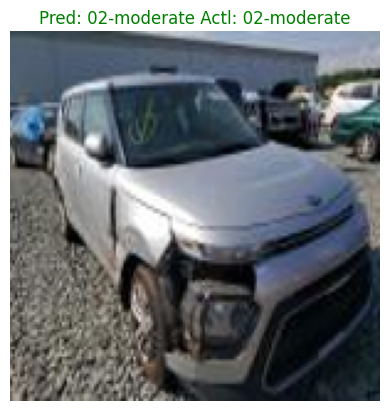

1/1 [==============================] - 0s 103ms/step


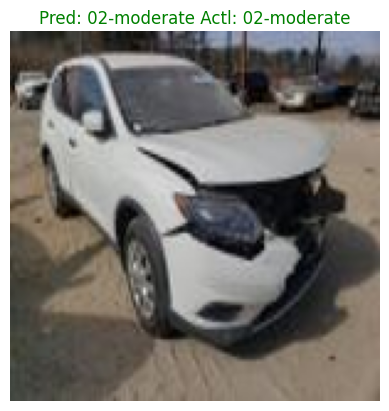

1/1 [==============================] - 0s 87ms/step


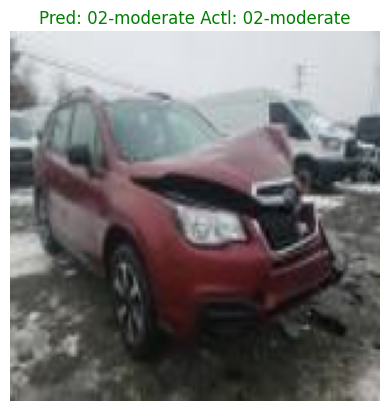

1/1 [==============================] - 0s 103ms/step


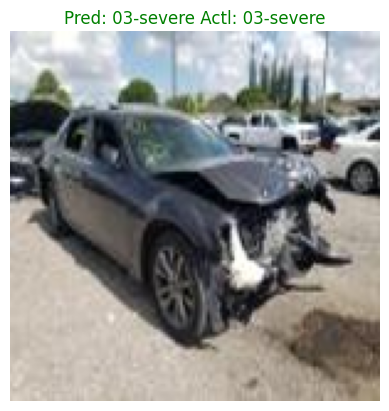

1/1 [==============================] - 0s 91ms/step


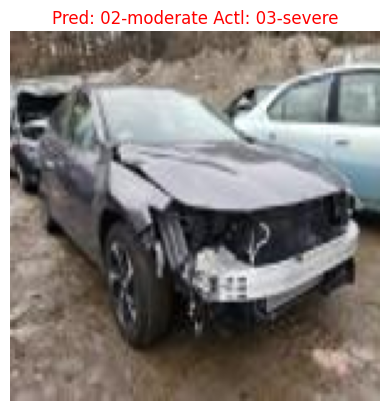

1/1 [==============================] - 0s 94ms/step


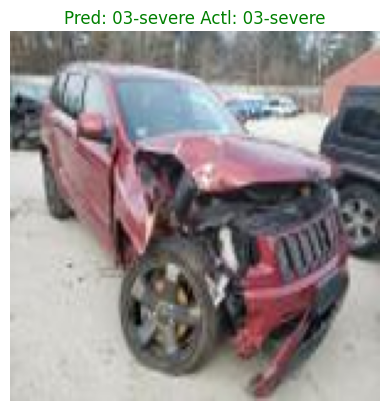

1/1 [==============================] - 0s 103ms/step


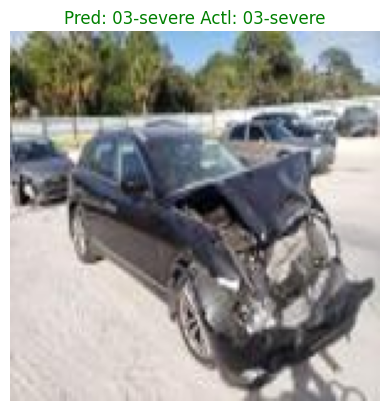

1/1 [==============================] - 0s 83ms/step


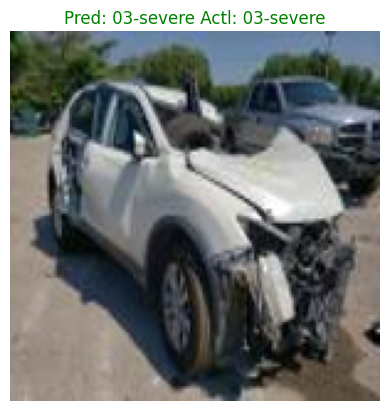

1/1 [==============================] - 0s 84ms/step


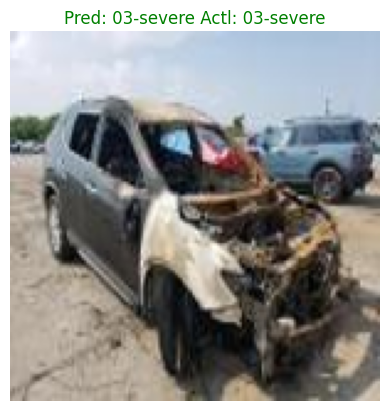

1/1 [==============================] - 0s 83ms/step


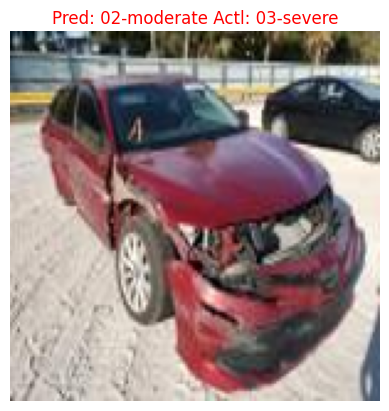

1/1 [==============================] - 0s 93ms/step


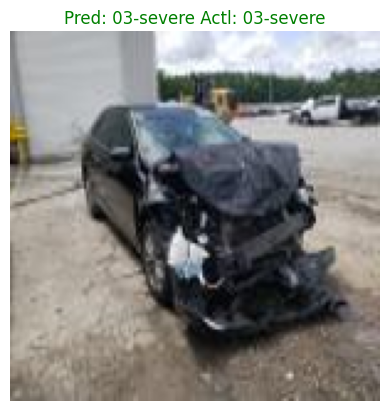

1/1 [==============================] - 0s 92ms/step


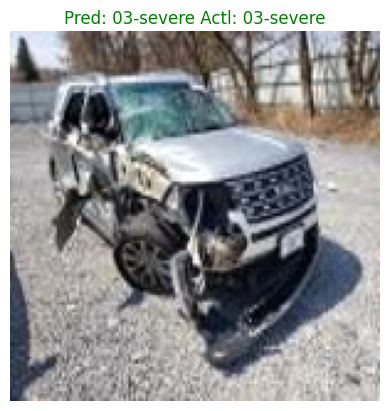

1/1 [==============================] - 0s 93ms/step


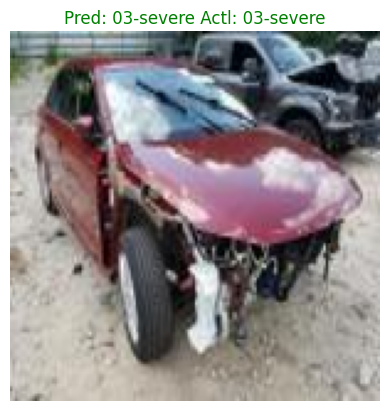

False: 6
True: 16


In [15]:
val_dir = 'data3a/validation'
class_names = ["01-minor", "02-moderate", "03-severe"]

image_paths = []
for class_name in class_names:
    folder_path = os.path.join(val_dir, class_name)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(folder_path, filename))
negative = 0
positive = 0
for image_path in image_paths:
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = img.resize((img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)
    pred = resnet_model.predict(img)
    pred_label = class_names[np.argmax(pred)]
    folder_name = os.path.basename(os.path.dirname(image_path))
    plt.imshow(img[0])
    if (pred_label != folder_name):
        plt.title('Pred: ' + pred_label + ' Actl: ' + folder_name, color = 'red')
        negative+=1
    else:
        plt.title('Pred: ' + pred_label + ' Actl: ' + folder_name, color = 'green')
        positive+=1
   
    plt.axis('off')
    plt.show() 
print('False: '+ str(negative) + '\nTrue: ' + str(positive))